# I. Data preparation

## A. Data import and pre-processing

In [1]:
# import all useful libraries
import pandas as pd
import datetime
import re #rationnal expression
import preprocessor as p #special package to pre-process tweet
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# to make this notebook's output identical at every run
np.random.seed(42)

In [3]:
#Data retrieval : load directly the dataset
tweets = pd.read_excel("/Users/GuillaumeKunsch/Desktop/TFM_Guillaume_Kunsch/Tweepy/tweets.xlsx")                
tweets

,text,lang,country,date,user_name,user_id,nb_of_tweets,user_creation_date,verified,filter_level,favorite,retweet,url
0,JUST IN: US Treasury Office propose new rule t...,en,None,Sat Nov 21 17:30:27 +0000 2020,LiviN,1201027291,25459,Wed Feb 20 13:23:38 +0000 2013,0,low,0,0,0
1,The Bullish Case for #Bitcoin\n@real_vijay \n👉...,en,None,Sat Nov 21 17:30:28 +0000 2020,StormJib.HODL,15893397,3313,Mon Aug 18 16:31:04 +0000 2008,0,low,0,0,1
2,"BITCOIN MOONING STEP BY STEP UPWARD TO $26,000...",en,None,Sat Nov 21 17:30:28 +0000 2020,George Fish,109361772,39,Thu Jan 28 20:23:57 +0000 2010,0,low,0,0,1
3,RT @Thunderblunder7: pokemon showdown was made...,en,None,Sat Nov 21 17:30:28 +0000 2020,Brandon 🐝🌳🇬🇭🖤 #JoyconBoy,1027954637331202049,67326,Fri Aug 10 16:27:38 +0000 2018,0,low,0,0,0
4,"I recently discussed inflation/deflation, stim...",en,None,Sat Nov 21 17:30:28 +0000 2020,Altperspective,837994867028459521,364,Sat Mar 04 11:55:20 +0000 2017,0,low,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
707713,RT @MMCrypto: #BITCOIN JUST BROKE THE 2019 HIG...,en,None,Sat Oct 31 11:49:43 +0000 2020,cryptoboss💥,4160950469,5946,Wed Nov 11 03:00:06 +0000 2015,0,low,0,0,0
707714,Sana all whale 👀,en,None,Sat Oct 31 11:49:43 +0000 2020,Jazz G🍀,996004058640007169,10411,Mon May 14 12:27:27 +0000 2018,0,low,0,0,0
707715,"RT @BarrySilbert: Hi @stoolpresidente, please ...",en,None,Sat Oct 31 11:49:43 +0000 2020,Светик Алимова,926774522161782785,78,Sat Nov 04 11:33:59 +0000 2017,0,low,0,0,0
707716,RT @100trillionUSD: Best present on #Bitcoin w...,en,None,Sat Oct 31 11:49:43 +0000 2020,Loedere.eth 🇧🇪 - ₿,420490529,7707,Thu Nov 24 18:03:50 +0000 2011,0,low,0,0,0


In [4]:
#Select only english tweets
tweets = tweets[tweets["lang"] == "en"]

In [5]:
hours = []
for date in tweets["date"]: #to keep only the hour
    hours.append(date[10:19])
tweets["hour"] = hours

dates = []
for date in tweets["date"]: #to keep only the date
    dates.append(date[:10])
tweets["new_date"] = dates

year = []
for date in tweets["date"]: #to keep only the year
    year.append(date[26:])
tweets["year"] = year

date_format = []
datetime_format = []

equivalent_m = {"Jan" : 1, "Feb" : 2, "Mar" : 3, "Apr" : 4, "May" : 5, "Jun": 6, "Jul" : 7, "Aug" : 8, "Sep" : 9, "Oct": 10, "Nov": 11, "Dec": 12}

for index, row in tweets.iterrows() :
    day = int(row["new_date"][8:])
    month = int(equivalent_m[row["new_date"][4:7]])
    year = int(row["year"])
    hour = int(row["hour"][0:3])
    minute = int(row["hour"][4:6])
    second = int(row["hour"][7:])
    date_format.append(datetime.date(year,month,day))
    datetime_format.append(datetime.datetime(year,month,day,hour,minute,second))
    
tweets["date_format"] = date_format
tweets["datetime_format"] = datetime_format

day_of_the_week=[]
equivalent_w = {"Mon" : 1, "Tue" : 2, "Wed" : 3, "Thu" : 4, "Fri" : 5, "Sat": 6, "Sun" : 7}

for date in tweets["new_date"]: 
    day = int(equivalent_w[date[:3]])
    day_of_the_week.append(day)
    
tweets["day"] = day_of_the_week #to store the day of the week the tweet was posted

tweets = tweets.drop(columns = ["new_date", "year"])
tweets.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

,text,lang,country,date,user_name,user_id,nb_of_tweets,user_creation_date,verified,filter_level,favorite,retweet,url,hour,date_format,datetime_format,day
0,JUST IN: US Treasury Office propose new rule t...,en,None,Sat Nov 21 17:30:27 +0000 2020,LiviN,1201027291,25459,Wed Feb 20 13:23:38 +0000 2013,0,low,0,0,0,17:30:27,2020-11-21,2020-11-21 17:30:27,6
1,The Bullish Case for #Bitcoin\n@real_vijay \n👉...,en,None,Sat Nov 21 17:30:28 +0000 2020,StormJib.HODL,15893397,3313,Mon Aug 18 16:31:04 +0000 2008,0,low,0,0,1,17:30:28,2020-11-21,2020-11-21 17:30:28,6
2,"BITCOIN MOONING STEP BY STEP UPWARD TO $26,000...",en,None,Sat Nov 21 17:30:28 +0000 2020,George Fish,109361772,39,Thu Jan 28 20:23:57 +0000 2010,0,low,0,0,1,17:30:28,2020-11-21,2020-11-21 17:30:28,6
3,RT @Thunderblunder7: pokemon showdown was made...,en,None,Sat Nov 21 17:30:28 +0000 2020,Brandon 🐝🌳🇬🇭🖤 #JoyconBoy,1027954637331202049,67326,Fri Aug 10 16:27:38 +0000 2018,0,low,0,0,0,17:30:28,2020-11-21,2020-11-21 17:30:28,6
4,"I recently discussed inflation/deflation, stim...",en,None,Sat Nov 21 17:30:28 +0000 2020,Altperspective,837994867028459521,364,Sat Mar 04 11:55:20 +0000 2017,0,low,0,0,0,17:30:28,2020-11-21,2020-11-21 17:30:28,6


In [6]:
#Change date creation of user account to an adequate format
dates = []
for date in tweets["user_creation_date"]: #to keep only the date
    dates.append(date[:10])
tweets["new_date"] = dates

year = []
for date in tweets["user_creation_date"]: #to keep only the  year
    year.append(date[26:])
tweets["year"] = year

date_format = []

equivalent_m = {"Jan" : 1, "Feb" : 2, "Mar" : 3, "Apr" : 4, "May" : 5, "Jun": 6, "Jul" : 7, "Aug" : 8, "Sep" : 9, "Oct": 10, "Nov": 11, "Dec": 12}

for index, row in tweets.iterrows() :
    day = int(row["new_date"][8:])
    month = int(equivalent_m[row["new_date"][4:7]])
    year = int(row["year"])
    date_format.append(datetime.date(year,month,day))
    
tweets["user_creation_date_format"] = date_format

tweets = tweets.drop(columns = ["new_date", "year"])

#Calculate average tweets per day per user

tweets_per_day = []
for index, row in tweets.iterrows() :
    date_begin = row["user_creation_date_format"]
    date_end = row["date_format"]
    life_span = date_end-date_begin
    if life_span.days == 0 :
        tweets_per_day = tweets_per_day + [row["nb_of_tweets"]]
    else : 
        tweets_per_day = tweets_per_day + [row["nb_of_tweets"]/life_span.days]

tweets["tweets_per_day"] = tweets_per_day
tweets.head()

,text,lang,country,date,user_name,user_id,nb_of_tweets,user_creation_date,verified,filter_level,favorite,retweet,url,hour,date_format,datetime_format,day,user_creation_date_format,tweets_per_day
0,JUST IN: US Treasury Office propose new rule t...,en,None,Sat Nov 21 17:30:27 +0000 2020,LiviN,1201027291,25459,Wed Feb 20 13:23:38 +0000 2013,0,low,0,0,0,17:30:27,2020-11-21,2020-11-21 17:30:27,6,2013-02-20,8.992935
1,The Bullish Case for #Bitcoin\n@real_vijay \n👉...,en,None,Sat Nov 21 17:30:28 +0000 2020,StormJib.HODL,15893397,3313,Mon Aug 18 16:31:04 +0000 2008,0,low,0,0,1,17:30:28,2020-11-21,2020-11-21 17:30:28,6,2008-08-18,0.739839
2,"BITCOIN MOONING STEP BY STEP UPWARD TO $26,000...",en,None,Sat Nov 21 17:30:28 +0000 2020,George Fish,109361772,39,Thu Jan 28 20:23:57 +0000 2010,0,low,0,0,1,17:30:28,2020-11-21,2020-11-21 17:30:28,6,2010-01-28,0.009873
3,RT @Thunderblunder7: pokemon showdown was made...,en,None,Sat Nov 21 17:30:28 +0000 2020,Brandon 🐝🌳🇬🇭🖤 #JoyconBoy,1027954637331202049,67326,Fri Aug 10 16:27:38 +0000 2018,0,low,0,0,0,17:30:28,2020-11-21,2020-11-21 17:30:28,6,2018-08-10,80.726619
4,"I recently discussed inflation/deflation, stim...",en,None,Sat Nov 21 17:30:28 +0000 2020,Altperspective,837994867028459521,364,Sat Mar 04 11:55:20 +0000 2017,0,low,0,0,0,17:30:28,2020-11-21,2020-11-21 17:30:28,6,2017-03-04,0.268041


In [7]:
#Arbitrary frontier (linked to our exploratory analysis)
tweets_filtered = tweets[tweets["tweets_per_day"] <=10 ]
tweets_filtered = tweets_filtered.reset_index(drop = True)
tweets_filtered

,text,lang,country,date,user_name,user_id,nb_of_tweets,user_creation_date,verified,filter_level,favorite,retweet,url,hour,date_format,datetime_format,day,user_creation_date_format,tweets_per_day
0,JUST IN: US Treasury Office propose new rule t...,en,None,Sat Nov 21 17:30:27 +0000 2020,LiviN,1201027291,25459,Wed Feb 20 13:23:38 +0000 2013,0,low,0,0,0,17:30:27,2020-11-21,2020-11-21 17:30:27,6,2013-02-20,8.992935
1,The Bullish Case for #Bitcoin\n@real_vijay \n👉...,en,None,Sat Nov 21 17:30:28 +0000 2020,StormJib.HODL,15893397,3313,Mon Aug 18 16:31:04 +0000 2008,0,low,0,0,1,17:30:28,2020-11-21,2020-11-21 17:30:28,6,2008-08-18,0.739839
2,"BITCOIN MOONING STEP BY STEP UPWARD TO $26,000...",en,None,Sat Nov 21 17:30:28 +0000 2020,George Fish,109361772,39,Thu Jan 28 20:23:57 +0000 2010,0,low,0,0,1,17:30:28,2020-11-21,2020-11-21 17:30:28,6,2010-01-28,0.009873
3,"I recently discussed inflation/deflation, stim...",en,None,Sat Nov 21 17:30:28 +0000 2020,Altperspective,837994867028459521,364,Sat Mar 04 11:55:20 +0000 2017,0,low,0,0,0,17:30:28,2020-11-21,2020-11-21 17:30:28,6,2017-03-04,0.268041
4,"Here comes the $OXT FUD. Sorry guy, if you mis...",en,None,Sat Nov 21 17:30:28 +0000 2020,Johnny One Punch 👊 Man,1965963320,14983,Thu Oct 17 02:58:49 +0000 2013,0,low,0,0,1,17:30:28,2020-11-21,2020-11-21 17:30:28,6,2013-10-17,5.780478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372505,🍀🍀 USD$100 #Election2020 #Crypto #Giveaway 🍀🍀\...,en,None,Sat Oct 31 11:49:39 +0000 2020,Warzuqnii fahmaan,3287406835,3452,Wed Jul 22 08:51:54 +0000 2015,0,low,0,0,0,11:49:39,2020-10-31,2020-10-31 11:49:39,6,2015-07-22,1.790456
372506,Quad 4 #Bitcoin. Wink 4 911.,en,None,Sat Oct 31 11:49:41 +0000 2020,Jason A Williams,1194984822,26437,Mon Feb 18 21:39:13 +0000 2013,0,low,0,0,0,11:49:41,2020-10-31,2020-10-31 11:49:41,6,2013-02-18,9.401494
372507,RT @MMCrypto: #BITCOIN JUST BROKE THE 2019 HIG...,en,None,Sat Oct 31 11:49:43 +0000 2020,cryptoboss💥,4160950469,5946,Wed Nov 11 03:00:06 +0000 2015,0,low,0,0,0,11:49:43,2020-10-31,2020-10-31 11:49:43,6,2015-11-11,3.274229
372508,"RT @BarrySilbert: Hi @stoolpresidente, please ...",en,None,Sat Oct 31 11:49:43 +0000 2020,Светик Алимова,926774522161782785,78,Sat Nov 04 11:33:59 +0000 2017,0,low,0,0,0,11:49:43,2020-10-31,2020-10-31 11:49:43,6,2017-11-04,0.071429


## B. Text processing

In [8]:
#to modify all tweets 
processed_tweet = []
for tweet in tweets_filtered["text"] :
    p.set_options(p.OPT.URL, p.OPT.MENTION,p.OPT.RESERVED) #not get rid of everything
    tweet = p.clean(tweet) 
    tweet = re.sub(r'^:', '', tweet) #to get rid of the first ':' in a few tweets (because of the RT that was taken off)
    processed_tweet.append(tweet)
processed_tweet

tweets_filtered["processed_text"] = processed_tweet
tweets_filtered

,text,lang,country,date,user_name,user_id,nb_of_tweets,user_creation_date,verified,filter_level,favorite,retweet,url,hour,date_format,datetime_format,day,user_creation_date_format,tweets_per_day,processed_text
0,JUST IN: US Treasury Office propose new rule t...,en,None,Sat Nov 21 17:30:27 +0000 2020,LiviN,1201027291,25459,Wed Feb 20 13:23:38 +0000 2013,0,low,0,0,0,17:30:27,2020-11-21,2020-11-21 17:30:27,6,2013-02-20,8.992935,JUST IN: US Treasury Office propose new rule t...
1,The Bullish Case for #Bitcoin\n@real_vijay \n👉...,en,None,Sat Nov 21 17:30:28 +0000 2020,StormJib.HODL,15893397,3313,Mon Aug 18 16:31:04 +0000 2008,0,low,0,0,1,17:30:28,2020-11-21,2020-11-21 17:30:28,6,2008-08-18,0.739839,"The Bullish Case for #Bitcoin 👉🏻 Gradually, Th..."
2,"BITCOIN MOONING STEP BY STEP UPWARD TO $26,000...",en,None,Sat Nov 21 17:30:28 +0000 2020,George Fish,109361772,39,Thu Jan 28 20:23:57 +0000 2010,0,low,0,0,1,17:30:28,2020-11-21,2020-11-21 17:30:28,6,2010-01-28,0.009873,"BITCOIN MOONING STEP BY STEP UPWARD TO $26,000..."
3,"I recently discussed inflation/deflation, stim...",en,None,Sat Nov 21 17:30:28 +0000 2020,Altperspective,837994867028459521,364,Sat Mar 04 11:55:20 +0000 2017,0,low,0,0,0,17:30:28,2020-11-21,2020-11-21 17:30:28,6,2017-03-04,0.268041,"I recently discussed inflation/deflation, stim..."
4,"Here comes the $OXT FUD. Sorry guy, if you mis...",en,None,Sat Nov 21 17:30:28 +0000 2020,Johnny One Punch 👊 Man,1965963320,14983,Thu Oct 17 02:58:49 +0000 2013,0,low,0,0,1,17:30:28,2020-11-21,2020-11-21 17:30:28,6,2013-10-17,5.780478,"Here comes the $OXT FUD. Sorry guy, if you mis..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372505,🍀🍀 USD$100 #Election2020 #Crypto #Giveaway 🍀🍀\...,en,None,Sat Oct 31 11:49:39 +0000 2020,Warzuqnii fahmaan,3287406835,3452,Wed Jul 22 08:51:54 +0000 2015,0,low,0,0,0,11:49:39,2020-10-31,2020-10-31 11:49:39,6,2015-07-22,1.790456,🍀🍀 USD$100 #Election2020 #Crypto #Giveaway 🍀🍀 ...
372506,Quad 4 #Bitcoin. Wink 4 911.,en,None,Sat Oct 31 11:49:41 +0000 2020,Jason A Williams,1194984822,26437,Mon Feb 18 21:39:13 +0000 2013,0,low,0,0,0,11:49:41,2020-10-31,2020-10-31 11:49:41,6,2013-02-18,9.401494,Quad 4 #Bitcoin. Wink 4 911.
372507,RT @MMCrypto: #BITCOIN JUST BROKE THE 2019 HIG...,en,None,Sat Oct 31 11:49:43 +0000 2020,cryptoboss💥,4160950469,5946,Wed Nov 11 03:00:06 +0000 2015,0,low,0,0,0,11:49:43,2020-10-31,2020-10-31 11:49:43,6,2015-11-11,3.274229,#BITCOIN JUST BROKE THE 2019 HIGH!
372508,"RT @BarrySilbert: Hi @stoolpresidente, please ...",en,None,Sat Oct 31 11:49:43 +0000 2020,Светик Алимова,926774522161782785,78,Sat Nov 04 11:33:59 +0000 2017,0,low,0,0,0,11:49:43,2020-10-31,2020-10-31 11:49:43,6,2017-11-04,0.071429,"Hi , please meet the family of crypto funds"


In [9]:
nltk.download('vader_lexicon')
analyser = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/GuillaumeKunsch/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [10]:
def get_sentiment(df):
    sentences = df["processed_text"]
    pos = []
    neg = []
    neu = []
    compound = []
    overall = []
    
    for sentence in sentences : 
        sentiment_dict = analyser.polarity_scores(sentence)
        pos.append(sentiment_dict['pos']*100)
        neg.append(sentiment_dict['neg']*100)
        neu.append(sentiment_dict['neu']*100)
        compound.append(sentiment_dict['compound']*100)
        
        if sentiment_dict['compound'] >= 0.05: #random treshold : usually used in the litterature that used VADER 
            overall.append(1) #positive
        elif sentiment_dict['compound'] <= - 0.05 :
            overall.append(-1) #negative
        else : 
            overall.append(0) #neutral
            
    df["pos"] = pos
    df["neg"] = neg 
    df["neu"] = neu 
    df["compound"] = compound 
    df["overall"] = overall 
    
get_sentiment(tweets_filtered)
tweets_filtered

,text,lang,country,date,user_name,user_id,nb_of_tweets,user_creation_date,verified,filter_level,...,datetime_format,day,user_creation_date_format,tweets_per_day,processed_text,pos,neg,neu,compound,overall
0,JUST IN: US Treasury Office propose new rule t...,en,None,Sat Nov 21 17:30:27 +0000 2020,LiviN,1201027291,25459,Wed Feb 20 13:23:38 +0000 2013,0,low,...,2020-11-21 17:30:27,6,2013-02-20,8.992935,JUST IN: US Treasury Office propose new rule t...,6.7,22.4,70.9,-63.69,-1
1,The Bullish Case for #Bitcoin\n@real_vijay \n👉...,en,None,Sat Nov 21 17:30:28 +0000 2020,StormJib.HODL,15893397,3313,Mon Aug 18 16:31:04 +0000 2008,0,low,...,2020-11-21 17:30:28,6,2008-08-18,0.739839,"The Bullish Case for #Bitcoin 👉🏻 Gradually, Th...",0.0,0.0,100.0,0.00,0
2,"BITCOIN MOONING STEP BY STEP UPWARD TO $26,000...",en,None,Sat Nov 21 17:30:28 +0000 2020,George Fish,109361772,39,Thu Jan 28 20:23:57 +0000 2010,0,low,...,2020-11-21 17:30:28,6,2010-01-28,0.009873,"BITCOIN MOONING STEP BY STEP UPWARD TO $26,000...",0.0,0.0,100.0,0.00,0
3,"I recently discussed inflation/deflation, stim...",en,None,Sat Nov 21 17:30:28 +0000 2020,Altperspective,837994867028459521,364,Sat Mar 04 11:55:20 +0000 2017,0,low,...,2020-11-21 17:30:28,6,2017-03-04,0.268041,"I recently discussed inflation/deflation, stim...",0.0,0.0,100.0,0.00,0
4,"Here comes the $OXT FUD. Sorry guy, if you mis...",en,None,Sat Nov 21 17:30:28 +0000 2020,Johnny One Punch 👊 Man,1965963320,14983,Thu Oct 17 02:58:49 +0000 2013,0,low,...,2020-11-21 17:30:28,6,2013-10-17,5.780478,"Here comes the $OXT FUD. Sorry guy, if you mis...",9.0,11.9,79.1,-14.69,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372505,🍀🍀 USD$100 #Election2020 #Crypto #Giveaway 🍀🍀\...,en,None,Sat Oct 31 11:49:39 +0000 2020,Warzuqnii fahmaan,3287406835,3452,Wed Jul 22 08:51:54 +0000 2015,0,low,...,2020-10-31 11:49:39,6,2015-07-22,1.790456,🍀🍀 USD$100 #Election2020 #Crypto #Giveaway 🍀🍀 ...,27.0,0.0,73.0,90.42,1
372506,Quad 4 #Bitcoin. Wink 4 911.,en,None,Sat Oct 31 11:49:41 +0000 2020,Jason A Williams,1194984822,26437,Mon Feb 18 21:39:13 +0000 2013,0,low,...,2020-10-31 11:49:41,6,2013-02-18,9.401494,Quad 4 #Bitcoin. Wink 4 911.,0.0,0.0,100.0,0.00,0
372507,RT @MMCrypto: #BITCOIN JUST BROKE THE 2019 HIG...,en,None,Sat Oct 31 11:49:43 +0000 2020,cryptoboss💥,4160950469,5946,Wed Nov 11 03:00:06 +0000 2015,0,low,...,2020-10-31 11:49:43,6,2015-11-11,3.274229,#BITCOIN JUST BROKE THE 2019 HIGH!,0.0,43.3,56.7,-58.93,-1
372508,"RT @BarrySilbert: Hi @stoolpresidente, please ...",en,None,Sat Oct 31 11:49:43 +0000 2020,Светик Алимова,926774522161782785,78,Sat Nov 04 11:33:59 +0000 2017,0,low,...,2020-10-31 11:49:43,6,2017-11-04,0.071429,"Hi , please meet the family of crypto funds",24.7,0.0,75.3,31.82,1


# II. Machine Learning Analysis

## A. Analysis per day 

### 1. Group result per day

In [11]:
tweets_analysis_by_day = tweets_filtered[["date_format","pos","neu","neg","compound"]]
tweets_grouped_by_day = tweets_analysis_by_day.groupby(by="date_format").mean()  #aggregate data 
tweets_grouped_by_day = tweets_grouped_by_day.reset_index()
tweets_grouped_by_day

,date_format,pos,neu,neg,compound
0,2020-06-26,15.928155,81.466019,2.606079,40.342550
1,2020-08-12,18.429573,79.685976,1.883232,43.686006
2,2020-08-14,17.889256,80.268803,1.841748,53.926654
3,2020-08-16,15.635958,81.917979,2.444269,41.783823
4,2020-08-17,11.907910,83.923454,4.164751,21.940720
...,...,...,...,...,...
69,2020-11-08,14.408243,82.501854,3.088534,30.592322
70,2020-11-19,14.962867,82.028531,3.008887,31.680557
71,2020-11-20,13.512528,82.883263,3.604956,25.518162
72,2020-11-21,12.543789,84.412145,3.044252,25.074342


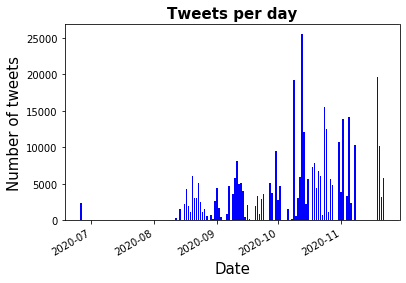

In [12]:
#Numbers of tweets per day : a high variance (depends on how the API gives us the data, free API not really reliable + CRON)

graph = tweets_analysis_by_day.groupby(by="date_format").count()
graph = graph.reset_index()
graph

x = graph["date_format"]
y = graph["pos"]
fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Date', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Tweets per day', fontsize=15, fontweight='bold')
plt.bar(x,y, color = "blue")
fig.autofmt_xdate()

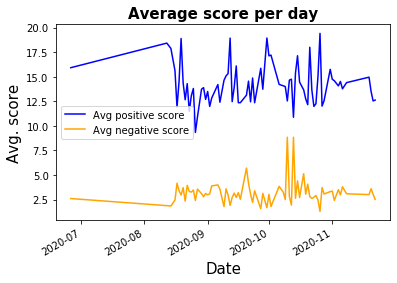

In [13]:
fig, ax = plt.subplots()
x_pos = tweets_grouped_by_day["date_format"]
y_pos = tweets_grouped_by_day["pos"]
x_neg = tweets_grouped_by_day["date_format"]
y_neg = tweets_grouped_by_day["neg"]
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Date', fontsize=15)
ax.set_ylabel('Avg. score' , fontsize=15)
ax.set_title('Average score per day', fontsize=15, fontweight='bold')
plt.plot(x_pos,y_pos, color = "blue")
plt.plot(x_neg,y_neg, color = "orange")
plt.legend(["Avg positive score", "Avg negative score"])
fig.autofmt_xdate()

It appears negative score is always below positive score : on avearage Bitcoin is positively seen on Twitter. But on some days negative trend gains momentum.

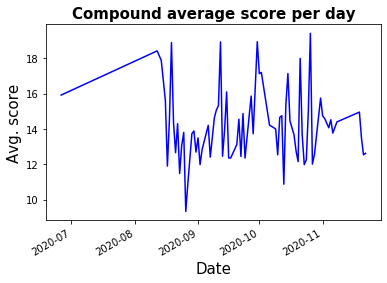

In [14]:
fig, ax = plt.subplots()
x_compound = tweets_grouped_by_day["date_format"]
y_compound = tweets_grouped_by_day["compound"]
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Date', fontsize=15)
ax.set_ylabel('Avg. score' , fontsize=15)
ax.set_title('Compound average score per day', fontsize=15, fontweight='bold')
plt.plot(x_pos,y_pos, color = "blue")
fig.autofmt_xdate()

In [15]:
#import Bitcoins data
data_btc_day = pd.read_csv("/Users/GuillaumeKunsch/Desktop/TFM_Guillaume_Kunsch/Binance/BTCUSDT-1d-data.csv")

In [16]:
#we consider variation on the same time frame
variation = []
for i in range (len(data_btc_day)) : 
    if data_btc_day["open"][i] >= data_btc_day["close"][i] : 
        variation = variation + [0] #decrease
    elif data_btc_day["open"][i] < data_btc_day["close"][i] : 
        variation = variation + [1] #increase
        
data_btc_day["variation_cat"] = variation
data_btc_day = data_btc_day.rename(columns = {'timestamp':'date_format'}) #rename column for future mergers
data_btc_day['date_format']= pd.to_datetime(data_btc_day['date_format']) #need to put back data_btc on datetime format 
data_btc_day


,Unnamed: 0,Unnamed: 0.1,date_format,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore,variation_cat
0,0,0.0,2020-06-13,9464.96,9494.73,9351.00,9473.34,27759.784851,1592092799999,2.616732e+08,392763,13531.007214,1.275772e+08,0,1
1,1,1.0,2020-06-14,9473.34,9480.99,9245.00,9342.10,30055.506608,1592179199999,2.821313e+08,415568,14465.416151,1.358116e+08,0,0
2,2,2.0,2020-06-15,9342.10,9495.00,8910.45,9426.02,86107.924707,1592265599999,7.935188e+08,839521,41630.747529,3.840311e+08,0,1
3,3,3.0,2020-06-16,9426.05,9589.00,9373.09,9525.59,52052.446927,1592351999999,4.944583e+08,543481,25692.839625,2.440974e+08,0,1
4,4,4.0,2020-06-17,9526.97,9565.00,9236.61,9465.14,48046.411152,1592438399999,4.532098e+08,536158,22842.831276,2.155327e+08,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,38,NaN,2021-01-10,40088.22,41350.00,35111.11,38150.02,118209.544503,1610323199999,4.604035e+09,2628050,55451.344673,2.160977e+09,0,0
213,39,NaN,2021-01-11,38150.02,38264.74,30420.00,35404.47,249131.539943,1610409599999,8.426880e+09,4431451,122133.406190,4.133116e+09,0,0
214,40,NaN,2021-01-12,35410.37,36628.00,32531.00,34051.24,133948.151996,1610495999999,4.651302e+09,2674145,65098.310196,2.261732e+09,0,0
215,41,NaN,2021-01-13,34049.15,37850.00,32380.00,37371.38,124477.914938,1610582399999,4.322877e+09,2514289,63981.038306,2.222873e+09,0,1


In [17]:
#Get the final dataset to train ML algorithms

tweets_grouped_by_day['date_format']= pd.to_datetime(tweets_grouped_by_day['date_format'])
final_data_day = pd.merge(tweets_grouped_by_day,data_btc_day,how='inner', on='date_format') #inner join 
final_data_day = final_data_day[["date_format","open","close","pos","neu","neg","compound","variation_cat"]] 
final_data_day["nb_of_tweets"]  = graph["pos"] #whatever column : warning it is not the real number of tweets posted on the time frame, but the tweets collected
final_data_day["variation"] = final_data_day["close"] - final_data_day["open"]
final_data_day["variation_%"] = (final_data_day["close"] - final_data_day["open"])/final_data_day["open"]*100

#Calculation of the variation with respect to the precedent row (Warning : because of the missing data it is not always in relation with the truly precedent value)

compound_variation = [float("NaN")]
for i in range (1,len(final_data_day)):
    new_var = (final_data_day["compound"][i]-final_data_day["compound"][i-1])/final_data_day["compound"][i-1]*100
    compound_variation = compound_variation + [new_var]


pos_variation = [float("NaN")]
for i in range (1,len(final_data_day)):
    new_var = (final_data_day["pos"][i]-final_data_day["pos"][i-1])/final_data_day["pos"][i-1]*100
    pos_variation = pos_variation + [new_var]
    

neg_variation = [float("NaN")]
for i in range (1,len(final_data_day)):
    new_var = (final_data_day["neg"][i]-final_data_day["neg"][i-1])/final_data_day["neg"][i-1]*100
    neg_variation = neg_variation + [new_var]


volume_variation = [float("NaN")]
for i in range (1,len(final_data_day)):
    new_var = (final_data_day["nb_of_tweets"][i]-final_data_day["nb_of_tweets"][i-1])/final_data_day["nb_of_tweets"][i-1]*100
    volume_variation = volume_variation + [new_var]

final_data_day["compound_variation%"] = compound_variation
final_data_day["pos_variation%"] = pos_variation
final_data_day["neg_variation%"] = neg_variation
final_data_day["nb_of_tweets_variation%"] = volume_variation
final_data_day

,date_format,open,close,pos,neu,neg,compound,variation_cat,nb_of_tweets,variation,variation_%,compound_variation%,pos_variation%,neg_variation%,nb_of_tweets_variation%
0,2020-06-26,9249.49,9162.21,15.928155,81.466019,2.606079,40.342550,0,2369,-87.28,-0.943620,NaN,NaN,NaN,NaN
1,2020-08-12,11392.09,11564.33,18.429573,79.685976,1.883232,43.686006,1,328,172.24,1.511926,8.287668,15.704379,-27.736954,-86.154496
2,2020-08-14,11779.77,11760.54,17.889256,80.268803,1.841748,53.926654,0,1545,-19.23,-0.163246,23.441483,-2.931796,-2.202816,371.036585
3,2020-08-16,11852.40,11911.00,15.635958,81.917979,2.444269,41.783823,1,2286,58.60,0.494415,-22.517308,-12.595816,32.714684,47.961165
4,2020-08-17,11910.99,12281.13,11.907910,83.923454,4.164751,21.940720,1,4349,370.14,3.107550,-47.489918,-23.842787,70.388354,90.244969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,2020-11-08,14818.30,15475.10,14.408243,82.501854,3.088534,30.592322,1,10300,656.80,4.432357,17.676429,4.595811,-18.884434,345.694505
70,2020-11-19,17777.75,17802.82,14.962867,82.028531,3.008887,31.680557,1,19670,25.07,0.141019,3.557216,3.849356,-2.578808,90.970874
71,2020-11-20,17802.81,18655.67,13.512528,82.883263,3.604956,25.518162,1,10169,852.86,4.790592,-19.451663,-9.692922,19.810305,-48.301983
72,2020-11-21,18655.66,18703.80,12.543789,84.412145,3.044252,25.074342,1,3236,48.14,0.258045,-1.739233,-7.169196,-15.553700,-68.177795


In [18]:
#not a linear relationships at all
corr_matrix = final_data_day.corr() #does not work to study correlations with a category: need numeric data
corr_matrix

,open,close,pos,neu,neg,compound,variation_cat,nb_of_tweets,variation,variation_%,compound_variation%,pos_variation%,neg_variation%,nb_of_tweets_variation%
open,1.000000,0.985619,-0.110705,0.134721,-0.024801,-0.243588,0.020307,0.305494,0.154792,0.114614,-0.048608,-0.055124,-0.070232,-0.065432
close,0.985619,1.000000,-0.098103,0.120329,-0.023490,-0.249116,0.129622,0.335996,0.319513,0.279233,-0.056212,-0.060809,-0.061455,-0.054222
pos,-0.110705,-0.098103,1.000000,-0.814147,-0.410365,0.759427,0.032937,-0.033411,0.047233,0.044759,0.221909,0.633554,-0.315902,-0.059941
neu,0.134721,0.120329,-0.814147,1.000000,-0.195416,-0.362957,-0.038458,-0.059419,-0.051962,-0.045938,-0.084466,-0.490795,-0.198646,0.087209
neg,-0.024801,-0.023490,-0.410365,-0.195416,1.000000,-0.712573,0.004691,0.149738,0.001740,-0.003526,-0.240797,-0.296354,0.843679,-0.036391
compound,-0.243588,-0.249116,0.759427,-0.362957,-0.712573,1.000000,-0.063563,-0.162676,-0.090508,-0.082139,0.247175,0.459310,-0.564564,0.054339
variation_cat,0.020307,0.129622,0.032937,-0.038458,0.004691,-0.063563,1.000000,0.085152,0.643950,0.667323,-0.146670,-0.026396,-0.030162,0.089797
nb_of_tweets,0.305494,0.335996,-0.033411,-0.059419,0.149738,-0.162676,0.085152,1.000000,0.251300,0.228503,0.108030,-0.008011,0.159185,0.398816
variation,0.154792,0.319513,0.047233,-0.051962,0.001740,-0.090508,0.643950,0.251300,1.000000,0.989810,-0.055252,-0.045715,0.034158,0.049313
variation_%,0.114614,0.279233,0.044759,-0.045938,-0.003526,-0.082139,0.667323,0.228503,0.989810,1.000000,-0.052781,-0.042106,0.032792,0.054100


In [19]:
final_data_day["variation_cat"].value_counts() #check if our  dataset is well balanced

1    42
0    32
Name: variation_cat, dtype: int64

### 2. Logistic Regression

In [20]:
input_ml_day = final_data_day[["pos","pos_variation%","neg","neg_variation%","compound","compound_variation%","nb_of_tweets","nb_of_tweets_variation%","variation_cat"]].drop(index = 0)  #choose variables

train_set, test_set = train_test_split(input_ml_day, test_size=0.2, random_state=42)

train_data = train_set.drop("variation_cat", axis=1) # drop labels for training set
train_data_label = train_set["variation_cat"].copy()

test_data = test_set.drop("variation_cat", axis=1)
test_data_label = test_set["variation_cat"].copy()

#standard preprocessing
scaler = preprocessing.StandardScaler().fit(train_data)
train_data_scaled = scaler.transform(train_data)
test_data_scaled = scaler.transform(test_data)

log_clf = LogisticRegression(solver="liblinear", random_state=42)
log_clf.fit(train_data_scaled, train_data_label)

test_data_scaled = scaler.transform(test_data)

y_pred = log_clf.predict(test_data_scaled)

print("Accuracy: {:.2f}%".format(100 * accuracy_score(test_data_label, y_pred)))
print("Precision: {:.2f}%".format(100 * precision_score(test_data_label, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(test_data_label, y_pred)))
print("f1 score: {:.2f}%".format(100 * f1_score(test_data_label, y_pred)))

confusion_matrix(test_data_label,y_pred)

Accuracy: 46.67%
Precision: 46.67%
Recall: 100.00%
f1 score: 63.64%


array([[0, 8],
       [0, 7]])

In [21]:
input_ml_day = final_data_day[["pos","neg","compound","nb_of_tweets", "variation_cat"]] #choose variables

train_set, test_set = train_test_split(input_ml_day, test_size=0.2, random_state=42)

train_data = train_set.drop("variation_cat", axis=1) # drop labels for training set
train_data_label = train_set["variation_cat"].copy()

test_data = test_set.drop("variation_cat", axis=1)
test_data_label = test_set["variation_cat"].copy()

#standard preprocessing
scaler = preprocessing.StandardScaler().fit(train_data)
train_data_scaled = scaler.transform(train_data)
test_data_scaled = scaler.transform(test_data)

log_clf = LogisticRegression(solver="liblinear", random_state=42)
log_clf.fit(train_data_scaled, train_data_label)

test_data_scaled = scaler.transform(test_data)

y_pred = log_clf.predict(test_data_scaled)

print("Accuracy: {:.2f}%".format(100 * accuracy_score(test_data_label, y_pred)))
print("Precision: {:.2f}%".format(100 * precision_score(test_data_label, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(test_data_label, y_pred)))
print("f1 score: {:.2f}%".format(100 * f1_score(test_data_label, y_pred)))

confusion_matrix(test_data_label,y_pred)

Accuracy: 46.67%
Precision: 50.00%
Recall: 75.00%
f1 score: 60.00%


array([[1, 6],
       [2, 6]])

In [22]:
input_ml_day = final_data_day[["pos_variation%","neg_variation%","compound_variation%","nb_of_tweets_variation%","variation_cat"]].drop(index = 0)  #choose variables

train_set, test_set = train_test_split(input_ml_day, test_size=0.2, random_state=42)

train_data = train_set.drop("variation_cat", axis=1) # drop labels for training set
train_data_label = train_set["variation_cat"].copy()

test_data = test_set.drop("variation_cat", axis=1)
test_data_label = test_set["variation_cat"].copy()

#standard preprocessing
scaler = preprocessing.StandardScaler().fit(train_data)
train_data_scaled = scaler.transform(train_data)
test_data_scaled = scaler.transform(test_data)

log_clf = LogisticRegression(solver="liblinear", random_state=42)
log_clf.fit(train_data_scaled, train_data_label)

test_data_scaled = scaler.transform(test_data)

y_pred = log_clf.predict(test_data_scaled)

print("Accuracy: {:.2f}%".format(100 * accuracy_score(test_data_label, y_pred)))
print("Precision: {:.2f}%".format(100 * precision_score(test_data_label, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(test_data_label, y_pred)))
print("f1 score: {:.2f}%".format(100 * f1_score(test_data_label, y_pred)))

confusion_matrix(test_data_label,y_pred)

Accuracy: 40.00%
Precision: 42.86%
Recall: 85.71%
f1 score: 57.14%


array([[0, 8],
       [1, 6]])

### 3. kNN

In [23]:
input_ml_day = final_data_day[["pos","pos_variation%","neg","neg_variation%","compound","compound_variation%","nb_of_tweets","nb_of_tweets_variation%","variation_cat"]].drop(index = 0)  #choose variables

train_set, test_set = train_test_split(input_ml_day, test_size=0.2, random_state=42)

train_data = train_set.drop("variation_cat", axis=1) # drop labels for training set
train_data_label = train_set["variation_cat"].copy()

test_data = test_set.drop("variation_cat", axis=1)
test_data_label = test_set["variation_cat"].copy()

#standard preprocessing
scaler = preprocessing.StandardScaler().fit(train_data)
train_data_scaled = scaler.transform(train_data)
test_data_scaled = scaler.transform(test_data)

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(train_data_scaled, train_data_label)

y_pred = neigh.predict(test_data_scaled)

print("Accuracy: {:.2f}%".format(100 * accuracy_score(test_data_label, y_pred)))
print("Precision: {:.2f}%".format(100 * precision_score(test_data_label, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(test_data_label, y_pred)))
print("f1 score: {:.2f}%".format(100 * f1_score(test_data_label, y_pred)))

confusion_matrix(test_data_label,y_pred)

Accuracy: 46.67%
Precision: 45.45%
Recall: 71.43%
f1 score: 55.56%


array([[2, 6],
       [2, 5]])

In [24]:
input_ml_day = final_data_day[["pos","neg","compound","nb_of_tweets","variation_cat"]] #choose variables

train_set, test_set = train_test_split(input_ml_day, test_size=0.2, random_state=42)

train_data = train_set.drop("variation_cat", axis=1) # drop labels for training set
train_data_label = train_set["variation_cat"].copy()

test_data = test_set.drop("variation_cat", axis=1)
test_data_label = test_set["variation_cat"].copy()

#standard preprocessing
scaler = preprocessing.StandardScaler().fit(train_data)
train_data_scaled = scaler.transform(train_data)
test_data_scaled = scaler.transform(test_data)

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(train_data_scaled, train_data_label)

y_pred = neigh.predict(test_data_scaled)

print("Accuracy: {:.2f}%".format(100 * accuracy_score(test_data_label, y_pred)))
print("Precision: {:.2f}%".format(100 * precision_score(test_data_label, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(test_data_label, y_pred)))
print("f1 score: {:.2f}%".format(100 * f1_score(test_data_label, y_pred)))

confusion_matrix(test_data_label,y_pred)

Accuracy: 53.33%
Precision: 57.14%
Recall: 50.00%
f1 score: 53.33%


array([[4, 3],
       [4, 4]])

In [25]:
input_ml_day = final_data_day[["pos_variation%","neg_variation%","compound_variation%","nb_of_tweets_variation%","variation_cat"]].drop(index = 0)  #choose variables

train_set, test_set = train_test_split(input_ml_day, test_size=0.2, random_state=42)

train_data = train_set.drop("variation_cat", axis=1) # drop labels for training set
train_data_label = train_set["variation_cat"].copy()

test_data = test_set.drop("variation_cat", axis=1)
test_data_label = test_set["variation_cat"].copy()

#standard preprocessing
scaler = preprocessing.StandardScaler().fit(train_data)
train_data_scaled = scaler.transform(train_data)
test_data_scaled = scaler.transform(test_data)

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(train_data_scaled, train_data_label)

y_pred = neigh.predict(test_data_scaled)

print("Accuracy: {:.2f}%".format(100 * accuracy_score(test_data_label, y_pred)))
print("Precision: {:.2f}%".format(100 * precision_score(test_data_label, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(test_data_label, y_pred)))
print("f1 score: {:.2f}%".format(100 * f1_score(test_data_label, y_pred)))

confusion_matrix(test_data_label,y_pred)

Accuracy: 53.33%
Precision: 50.00%
Recall: 71.43%
f1 score: 58.82%


array([[3, 5],
       [2, 5]])

### 4. Random Forests

In [26]:
input_ml_day = final_data_day[["pos","pos_variation%","neg","neg_variation%","compound","compound_variation%","nb_of_tweets","nb_of_tweets_variation%","variation_cat"]].drop(index = 0)  #choose variables

train_set, test_set = train_test_split(input_ml_day, test_size=0.2, random_state=42)

train_data = train_set.drop("variation_cat", axis=1) # drop labels for training set
train_data_label = train_set["variation_cat"].copy()

test_data = test_set.drop("variation_cat", axis=1)
test_data_label = test_set["variation_cat"].copy()

#standard preprocessing
scaler = preprocessing.StandardScaler().fit(train_data)
train_data_scaled = scaler.transform(train_data)
test_data_scaled = scaler.transform(test_data)

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(train_data_scaled, train_data_label)

y_pred = clf.predict(test_data_scaled)

print("Accuracy: {:.2f}%".format(100 * accuracy_score(test_data_label, y_pred)))
print("Precision: {:.2f}%".format(100 * precision_score(test_data_label, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(test_data_label, y_pred)))
print("f1 score: {:.2f}%".format(100 * f1_score(test_data_label, y_pred)))

confusion_matrix(test_data_label,y_pred)


Accuracy: 40.00%
Precision: 40.00%
Recall: 57.14%
f1 score: 47.06%


array([[2, 6],
       [3, 4]])

In [27]:
feature_names = train_data.columns
for name, score in zip(feature_names, clf.feature_importances_):
    print("%s (%f)" % (name, score))

pos (0.109095)
pos_variation% (0.099155)
neg (0.178625)
neg_variation% (0.095494)
compound (0.109691)
compound_variation% (0.101717)
nb_of_tweets (0.179463)
nb_of_tweets_variation% (0.126759)


In [28]:
input_ml_day = final_data_day[["pos","neg","compound","nb_of_tweets","variation_cat"]] #choose variables

train_set, test_set = train_test_split(input_ml_day, test_size=0.2, random_state=42)

train_data = train_set.drop("variation_cat", axis=1) # drop labels for training set
train_data_label = train_set["variation_cat"].copy()

test_data = test_set.drop("variation_cat", axis=1)
test_data_label = test_set["variation_cat"].copy()

#standard preprocessing
scaler = preprocessing.StandardScaler().fit(train_data)
train_data_scaled = scaler.transform(train_data)
test_data_scaled = scaler.transform(test_data)

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(train_data_scaled, train_data_label)

y_pred = clf.predict(test_data_scaled)

print("Accuracy: {:.2f}%".format(100 * accuracy_score(test_data_label, y_pred)))
print("Precision: {:.2f}%".format(100 * precision_score(test_data_label, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(test_data_label, y_pred)))
print("f1 score: {:.2f}%".format(100 * f1_score(test_data_label, y_pred)))

confusion_matrix(test_data_label,y_pred)

Accuracy: 40.00%
Precision: 45.45%
Recall: 62.50%
f1 score: 52.63%


array([[1, 6],
       [3, 5]])

In [29]:
feature_names = train_data.columns
for name, score in zip(feature_names, clf.feature_importances_):
    print("%s (%f)" % (name, score))

pos (0.220843)
neg (0.185114)
compound (0.221476)
nb_of_tweets (0.372567)


In [30]:
input_ml_day = final_data_day[["pos_variation%","neg_variation%","compound_variation%","nb_of_tweets_variation%","variation_cat"]].drop(index = 0)  #choose variables

train_set, test_set = train_test_split(input_ml_day, test_size=0.2, random_state=42)

train_data = train_set.drop("variation_cat", axis=1) # drop labels for training set
train_data_label = train_set["variation_cat"].copy()

test_data = test_set.drop("variation_cat", axis=1)
test_data_label = test_set["variation_cat"].copy()

#standard preprocessing
scaler = preprocessing.StandardScaler().fit(train_data)
train_data_scaled = scaler.transform(train_data)
test_data_scaled = scaler.transform(test_data)

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(train_data_scaled, train_data_label)

y_pred = clf.predict(test_data_scaled)

print("Accuracy: {:.2f}%".format(100 * accuracy_score(test_data_label, y_pred)))
print("Precision: {:.2f}%".format(100 * precision_score(test_data_label, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(test_data_label, y_pred)))
print("f1 score: {:.2f}%".format(100 * f1_score(test_data_label, y_pred)))

confusion_matrix(test_data_label,y_pred)

Accuracy: 53.33%
Precision: 50.00%
Recall: 71.43%
f1 score: 58.82%


array([[3, 5],
       [2, 5]])

In [31]:
feature_names = train_data.columns
for name, score in zip(feature_names, clf.feature_importances_):
    print("%s (%f)" % (name, score))

pos_variation% (0.198523)
neg_variation% (0.185601)
compound_variation% (0.332717)
nb_of_tweets_variation% (0.283159)


## B. Analysis per hour 

### 1. Group results per hour

In [32]:
tweets_analysis_by_hour = tweets_filtered[["datetime_format","pos","neu","neg","compound"]]
tweets_grouped_by_hour = tweets_analysis_by_hour.groupby(pd.Grouper(key="datetime_format", freq = "1H")).mean() #aggregate data
tweets_grouped_by_hour =  tweets_grouped_by_hour.dropna()  #drop time frame where we didn't collect any tweet 
tweets_grouped_by_hour = tweets_grouped_by_hour.reset_index()
tweets_grouped_by_hour

,datetime_format,pos,neu,neg,compound
0,2020-06-26 12:00:00,16.706369,79.598726,3.696178,32.444968
1,2020-06-26 13:00:00,15.809246,81.751338,2.439513,41.549285
2,2020-08-12 16:00:00,18.429573,79.685976,1.883232,43.686006
3,2020-08-14 14:00:00,17.889256,80.268803,1.841748,53.926654
4,2020-08-16 16:00:00,15.621114,81.846921,2.529717,40.757370
...,...,...,...,...,...
195,2020-11-21 18:00:00,12.007402,84.948116,3.044347,24.536521
196,2020-11-22 09:00:00,14.790814,82.386221,2.824843,32.603862
197,2020-11-22 10:00:00,13.895882,83.922216,2.181845,30.870882
198,2020-11-22 11:00:00,12.416062,84.810188,2.773704,26.296365


In [33]:
#import Bitcoins data
data_btc_1hour = pd.read_csv("/Users/GuillaumeKunsch/Desktop/TFM_Guillaume_Kunsch/Binance/BTCUSDT-1h-data.csv")

#we consider variation on the same time frame 
variation = []
for i in range (len(data_btc_1hour)) : 
    if data_btc_1hour["open"][i] >= data_btc_1hour["close"][i] : 
        variation = variation + [0] #decrease
    elif data_btc_1hour["open"][i] < data_btc_1hour["close"][i] : 
        variation = variation + [1] #increase
        
data_btc_1hour["variation_cat"] = variation
data_btc_1hour = data_btc_1hour.rename(columns = {'timestamp':'datetime_format'}) #rename column for future mergers
data_btc_1hour['datetime_format']= pd.to_datetime(data_btc_1hour['datetime_format']) #need to put back data_btc on datetime format 
data_btc_1hour


,Unnamed: 0,datetime_format,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore,variation_cat
0,0,2020-06-13 00:00:00,9464.96,9477.18,9431.05,9446.76,1347.107225,1592009999999,1.272985e+07,21789,560.837354,5.299574e+06,0,0
1,1,2020-06-13 01:00:00,9446.67,9449.89,9423.00,9442.45,741.003726,1592013599999,6.992785e+06,14154,351.087252,3.313188e+06,0,0
2,2,2020-06-13 02:00:00,9442.34,9442.34,9409.87,9426.57,715.462614,1592017199999,6.744837e+06,12943,336.825691,3.175585e+06,0,0
3,3,2020-06-13 03:00:00,9426.58,9431.90,9398.49,9408.54,1033.337333,1592020799999,9.732715e+06,13923,561.418947,5.288192e+06,0,0
4,4,2020-06-13 04:00:00,9408.54,9410.00,9362.08,9407.60,1768.051802,1592024399999,1.660003e+07,21481,820.629390,7.705820e+06,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5158,5158,2021-01-14 06:00:00,37529.11,38100.00,37440.00,37837.21,3705.587755,1610607599999,1.401213e+08,73541,1841.116843,6.965356e+07,0,1
5159,5159,2021-01-14 07:00:00,37837.20,38596.92,37703.09,38198.34,5294.802195,1610611199999,2.028865e+08,107847,2818.319058,1.080024e+08,0,1
5160,5160,2021-01-14 08:00:00,38199.52,38786.10,38192.64,38370.01,3936.809626,1610614799999,1.516776e+08,96897,2022.192144,7.792238e+07,0,1
5161,5161,2021-01-14 09:00:00,38370.01,38464.13,37862.04,37938.11,3551.706141,1610618399999,1.356779e+08,97054,1679.065733,6.415879e+07,0,0


In [34]:
#Get the final dataset to train ML algorithms

graph = tweets_analysis_by_hour.groupby(pd.Grouper(key="datetime_format", freq = "1H")).count()
graph = graph[graph['pos'] !=0] #get rid of all time frames where we didn't collect any tweets
graph = graph.reset_index()

tweets_grouped_by_hour['datetime_format']= pd.to_datetime(tweets_grouped_by_hour['datetime_format'])
final_data_1hour = pd.merge(tweets_grouped_by_hour,data_btc_1hour,how='inner', on='datetime_format') #inner join 
final_data_1hour = final_data_1hour[["datetime_format","open","close","pos","neu","neg","compound","variation_cat"]] 
final_data_1hour["nb_of_tweets"]  = graph["pos"] #whatever column : warning it is not the real number of tweets posted on the time frame, but the tweets collected
final_data_1hour["variation"] = final_data_1hour["close"] - final_data_1hour["open"]
final_data_1hour["variation_%"] = (final_data_1hour["close"] - final_data_1hour["open"])/final_data_1hour["open"]*100

#Calculation of the variation with respect to the precedent row (Warning : because of the missing data it is not always in relation with the truly precedent value)

compound_variation = [float("NaN")]
for i in range (1,len(final_data_1hour)):
    new_var = (final_data_1hour["compound"][i]-final_data_1hour["compound"][i-1])/final_data_1hour["compound"][i-1]*100
    compound_variation = compound_variation + [new_var]


pos_variation = [float("NaN")]
for i in range (1,len(final_data_1hour)):
    new_var = (final_data_1hour["pos"][i]-final_data_1hour["pos"][i-1])/final_data_1hour["pos"][i-1]*100
    pos_variation = pos_variation + [new_var]
    

neg_variation = [float("NaN")]
for i in range (1,len(final_data_1hour)):
    new_var = (final_data_1hour["neg"][i]-final_data_1hour["neg"][i-1])/final_data_1hour["neg"][i-1]*100
    neg_variation = neg_variation + [new_var]


volume_variation = [float("NaN")]
for i in range (1,len(final_data_1hour)):
    new_var = (final_data_1hour["nb_of_tweets"][i]-final_data_1hour["nb_of_tweets"][i-1])/final_data_1hour["nb_of_tweets"][i-1]*100
    volume_variation = volume_variation + [new_var]

final_data_1hour["compound_variation%"] = compound_variation
final_data_1hour["pos_variation%"] = pos_variation
final_data_1hour["neg_variation%"] = neg_variation
final_data_1hour["nb_of_tweets_variation%"] = volume_variation
final_data_1hour

,datetime_format,open,close,pos,neu,neg,compound,variation_cat,nb_of_tweets,variation,variation_%,compound_variation%,pos_variation%,neg_variation%,nb_of_tweets_variation%
0,2020-06-26 12:00:00,9189.38,9207.99,16.706369,79.598726,3.696178,32.444968,1,314,18.61,0.202516,NaN,NaN,NaN,NaN
1,2020-06-26 13:00:00,9207.99,9151.78,15.809246,81.751338,2.439513,41.549285,0,2055,-56.21,-0.610448,28.060797,-5.369950,-33.999035,554.458599
2,2020-08-12 16:00:00,11581.54,11547.90,18.429573,79.685976,1.883232,43.686006,0,328,-33.64,-0.290462,5.142619,16.574652,-22.802977,-84.038929
3,2020-08-14 14:00:00,11714.01,11706.71,17.889256,80.268803,1.841748,53.926654,0,1545,-7.30,-0.062319,23.441483,-2.931796,-2.202816,371.036585
4,2020-08-16 16:00:00,11859.91,11864.74,15.621114,81.846921,2.529717,40.757370,1,1023,4.83,0.040725,-24.420731,-12.678791,37.354139,-33.786408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,2020-11-21 18:00:00,18762.30,18735.47,12.007402,84.948116,3.044347,24.536521,0,1486,-26.83,-0.143000,-3.895290,-7.630088,0.005775,-15.085714
196,2020-11-22 09:00:00,18211.66,18379.07,14.790814,82.386221,2.824843,32.603862,1,479,167.41,0.919246,32.878913,23.180799,-7.210210,-67.765814
197,2020-11-22 10:00:00,18379.06,18172.45,13.895882,83.922216,2.181845,30.870882,0,1724,-206.61,-1.124160,-5.315262,-6.050597,-22.762284,259.916493
198,2020-11-22 11:00:00,18172.44,17887.82,12.416062,84.810188,2.773704,26.296365,0,2179,-284.62,-1.566218,-14.818224,-10.649337,27.126542,26.392111


In [35]:
final_data_1hour["variation_cat"].value_counts() #check if our dataset is well balanced

1    111
0     89
Name: variation_cat, dtype: int64

### 2. Logistic Regression

In [36]:
input_ml_1h = final_data_1hour[["pos","pos_variation%","neg","neg_variation%","compound","compound_variation%","nb_of_tweets","nb_of_tweets_variation%","variation_cat"]].drop(index = 0)  #choose variables

train_set, test_set = train_test_split(input_ml_1h, test_size=0.2, random_state=42)

train_data = train_set.drop("variation_cat", axis=1) # drop labels for training set
train_data_label = train_set["variation_cat"].copy()

test_data = test_set.drop("variation_cat", axis=1)
test_data_label = test_set["variation_cat"].copy()

#Standard preprocessing
scaler = preprocessing.StandardScaler().fit(train_data)
train_data_scaled = scaler.transform(train_data)
test_data_scaled = scaler.transform(test_data)

log_clf = LogisticRegression(solver="liblinear", random_state=42)
log_clf.fit(train_data_scaled, train_data_label)

test_data_scaled = scaler.transform(test_data)

y_pred = log_clf.predict(test_data_scaled)

print("Accuracy: {:.2f}%".format(100 * accuracy_score(test_data_label, y_pred)))
print("Precision: {:.2f}%".format(100 * precision_score(test_data_label, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(test_data_label, y_pred)))
print("f1 score: {:.2f}%".format(100 * f1_score(test_data_label, y_pred)))

confusion_matrix(test_data_label,y_pred)

Accuracy: 55.00%
Precision: 62.07%
Recall: 72.00%
f1 score: 66.67%


array([[ 4, 11],
       [ 7, 18]])

In [37]:
input_ml_1h = final_data_1hour[["pos","neg","compound","nb_of_tweets","variation_cat"]]  #choose variables

train_set, test_set = train_test_split(input_ml_1h, test_size=0.2, random_state=42)

train_data = train_set.drop("variation_cat", axis=1) # drop labels for training set
train_data_label = train_set["variation_cat"].copy()

test_data = test_set.drop("variation_cat", axis=1)
test_data_label = test_set["variation_cat"].copy()

#Standard preprocessing
scaler = preprocessing.StandardScaler().fit(train_data)
train_data_scaled = scaler.transform(train_data)
test_data_scaled = scaler.transform(test_data)

log_clf = LogisticRegression(solver="liblinear", random_state=42)
log_clf.fit(train_data_scaled, train_data_label)

test_data_scaled = scaler.transform(test_data)

y_pred = log_clf.predict(test_data_scaled)

print("Accuracy: {:.2f}%".format(100 * accuracy_score(test_data_label, y_pred)))
print("Precision: {:.2f}%".format(100 * precision_score(test_data_label, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(test_data_label, y_pred)))
print("f1 score: {:.2f}%".format(100 * f1_score(test_data_label, y_pred)))

confusion_matrix(test_data_label,y_pred)

Accuracy: 52.50%
Precision: 68.00%
Recall: 60.71%
f1 score: 64.15%


array([[ 4,  8],
       [11, 17]])

In [38]:
input_ml_1h = final_data_1hour[["pos_variation%","neg_variation%","compound_variation%","nb_of_tweets_variation%","variation_cat"]].drop(index = 0)  #choose variables

train_set, test_set = train_test_split(input_ml_1h, test_size=0.2, random_state=42)

train_data = train_set.drop("variation_cat", axis=1) # drop labels for training set
train_data_label = train_set["variation_cat"].copy()

test_data = test_set.drop("variation_cat", axis=1)
test_data_label = test_set["variation_cat"].copy()

#Standard preprocessing
scaler = preprocessing.StandardScaler().fit(train_data)
train_data_scaled = scaler.transform(train_data)
test_data_scaled = scaler.transform(test_data)

log_clf = LogisticRegression(solver="liblinear", random_state=42)
log_clf.fit(train_data_scaled, train_data_label)

test_data_scaled = scaler.transform(test_data)

y_pred = log_clf.predict(test_data_scaled)

print("Accuracy: {:.2f}%".format(100 * accuracy_score(test_data_label, y_pred)))
print("Precision: {:.2f}%".format(100 * precision_score(test_data_label, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(test_data_label, y_pred)))
print("f1 score: {:.2f}%".format(100 * f1_score(test_data_label, y_pred)))

confusion_matrix(test_data_label,y_pred)

Accuracy: 52.50%
Precision: 62.50%
Recall: 60.00%
f1 score: 61.22%


array([[ 6,  9],
       [10, 15]])

### 3. kNN

In [39]:
input_ml_1h = final_data_1hour[["pos","pos_variation%","neg","neg_variation%","compound","compound_variation%","nb_of_tweets","nb_of_tweets_variation%","variation_cat"]].drop(index = 0)  #choose variables

train_set, test_set = train_test_split(input_ml_1h, test_size=0.2, random_state=42)

train_data = train_set.drop("variation_cat", axis=1) # drop labels for training set
train_data_label = train_set["variation_cat"].copy()

test_data = test_set.drop("variation_cat", axis=1)
test_data_label = test_set["variation_cat"].copy()

#Standard preprocessing
scaler = preprocessing.StandardScaler().fit(train_data)
train_data_scaled = scaler.transform(train_data)
test_data_scaled = scaler.transform(test_data)

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(train_data_scaled, train_data_label)

y_pred = neigh.predict(test_data_scaled)

print("Accuracy: {:.2f}%".format(100 * accuracy_score(test_data_label, y_pred)))
print("Precision: {:.2f}%".format(100 * precision_score(test_data_label, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(test_data_label, y_pred)))
print("f1 score: {:.2f}%".format(100 * f1_score(test_data_label, y_pred)))

confusion_matrix(test_data_label,y_pred)

Accuracy: 47.50%
Precision: 59.09%
Recall: 52.00%
f1 score: 55.32%


array([[ 6,  9],
       [12, 13]])

In [40]:
input_ml_1h = final_data_1hour[["pos","neg","compound","nb_of_tweets","variation_cat"]]  #choose variables

train_set, test_set = train_test_split(input_ml_1h, test_size=0.2, random_state=42)

train_data = train_set.drop("variation_cat", axis=1) # drop labels for training set
train_data_label = train_set["variation_cat"].copy()

test_data = test_set.drop("variation_cat", axis=1)
test_data_label = test_set["variation_cat"].copy()

#Standard preprocessing
scaler = preprocessing.StandardScaler().fit(train_data)
train_data_scaled = scaler.transform(train_data)
test_data_scaled = scaler.transform(test_data)

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(train_data_scaled, train_data_label)

y_pred = neigh.predict(test_data_scaled)

print("Accuracy: {:.2f}%".format(100 * accuracy_score(test_data_label, y_pred)))
print("Precision: {:.2f}%".format(100 * precision_score(test_data_label, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(test_data_label, y_pred)))
print("f1 score: {:.2f}%".format(100 * f1_score(test_data_label, y_pred)))

confusion_matrix(test_data_label,y_pred)

Accuracy: 52.50%
Precision: 69.57%
Recall: 57.14%
f1 score: 62.75%


array([[ 5,  7],
       [12, 16]])

In [41]:
input_ml_1h = final_data_1hour[["pos_variation%","neg_variation%","compound_variation%","nb_of_tweets_variation%","variation_cat"]].drop(index = 0)  #choose variables
train_set, test_set = train_test_split(input_ml_1h, test_size=0.2, random_state=42)

train_data = train_set.drop("variation_cat", axis=1) # drop labels for training set
train_data_label = train_set["variation_cat"].copy()

test_data = test_set.drop("variation_cat", axis=1)
test_data_label = test_set["variation_cat"].copy()

#Standard preprocessing
scaler = preprocessing.StandardScaler().fit(train_data)
train_data_scaled = scaler.transform(train_data)
test_data_scaled = scaler.transform(test_data)

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(train_data_scaled, train_data_label)

y_pred = neigh.predict(test_data_scaled)

print("Accuracy: {:.2f}%".format(100 * accuracy_score(test_data_label, y_pred)))
print("Precision: {:.2f}%".format(100 * precision_score(test_data_label, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(test_data_label, y_pred)))
print("f1 score: {:.2f}%".format(100 * f1_score(test_data_label, y_pred)))

confusion_matrix(test_data_label,y_pred)

Accuracy: 65.00%
Precision: 76.19%
Recall: 64.00%
f1 score: 69.57%


array([[10,  5],
       [ 9, 16]])

### 4. Random Forests

In [42]:
input_ml_1h = final_data_1hour[["pos","pos_variation%","neg","neg_variation%","compound","compound_variation%","nb_of_tweets","nb_of_tweets_variation%","variation_cat"]].drop(index = 0)  #choose variables

train_set, test_set = train_test_split(input_ml_1h, test_size=0.2, random_state=42)

train_data = train_set.drop("variation_cat", axis=1) # drop labels for training set
train_data_label = train_set["variation_cat"].copy()

test_data = test_set.drop("variation_cat", axis=1)
test_data_label = test_set["variation_cat"].copy()

#Standard preprocessing
scaler = preprocessing.StandardScaler().fit(train_data)
train_data_scaled = scaler.transform(train_data)
test_data_scaled = scaler.transform(test_data)

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(train_data_scaled, train_data_label)

y_pred = clf.predict(test_data_scaled)

print("Accuracy: {:.2f}%".format(100 * accuracy_score(test_data_label, y_pred)))
print("Precision: {:.2f}%".format(100 * precision_score(test_data_label, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(test_data_label, y_pred)))
print("f1 score: {:.2f}%".format(100 * f1_score(test_data_label, y_pred)))

confusion_matrix(test_data_label,y_pred)

Accuracy: 40.00%
Precision: 52.63%
Recall: 40.00%
f1 score: 45.45%


array([[ 6,  9],
       [15, 10]])

In [43]:
feature_names = train_data.columns
for name, score in zip(feature_names, clf.feature_importances_):
    print("%s (%f)" % (name, score))

pos (0.054551)
pos_variation% (0.114988)
neg (0.171198)
neg_variation% (0.171657)
compound (0.066017)
compound_variation% (0.137546)
nb_of_tweets (0.178677)
nb_of_tweets_variation% (0.105366)


In [44]:
input_ml_1h = final_data_1hour[["pos","neg","compound","nb_of_tweets","variation_cat"]]  #choose variables

train_set, test_set = train_test_split(input_ml_1h, test_size=0.2, random_state=42)

train_data = train_set.drop("variation_cat", axis=1) # drop labels for training set
train_data_label = train_set["variation_cat"].copy()

test_data = test_set.drop("variation_cat", axis=1)
test_data_label = test_set["variation_cat"].copy()

#Standard preprocessing
scaler = preprocessing.StandardScaler().fit(train_data)
train_data_scaled = scaler.transform(train_data)
test_data_scaled = scaler.transform(test_data)

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(train_data_scaled, train_data_label)

y_pred = clf.predict(test_data_scaled)

print("Accuracy: {:.2f}%".format(100 * accuracy_score(test_data_label, y_pred)))
print("Precision: {:.2f}%".format(100 * precision_score(test_data_label, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(test_data_label, y_pred)))
print("f1 score: {:.2f}%".format(100 * f1_score(test_data_label, y_pred)))

confusion_matrix(test_data_label,y_pred)

Accuracy: 55.00%
Precision: 70.83%
Recall: 60.71%
f1 score: 65.38%


array([[ 5,  7],
       [11, 17]])

In [45]:
feature_names = train_data.columns
for name, score in zip(feature_names, clf.feature_importances_):
    print("%s (%f)" % (name, score))

pos (0.238877)
neg (0.169748)
compound (0.259598)
nb_of_tweets (0.331777)


In [46]:
input_ml_1h = final_data_1hour[["pos_variation%","neg_variation%","compound_variation%","nb_of_tweets_variation%","variation_cat"]].drop(index = 0)  #choose variables

train_set, test_set = train_test_split(input_ml_1h, test_size=0.2, random_state=42)

train_data = train_set.drop("variation_cat", axis=1) # drop labels for training set
train_data_label = train_set["variation_cat"].copy()

test_data = test_set.drop("variation_cat", axis=1)
test_data_label = test_set["variation_cat"].copy()

#Standard preprocessing
scaler = preprocessing.StandardScaler().fit(train_data)
train_data_scaled = scaler.transform(train_data)
test_data_scaled = scaler.transform(test_data)

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(train_data_scaled, train_data_label)

y_pred = clf.predict(test_data_scaled)

print("Accuracy: {:.2f}%".format(100 * accuracy_score(test_data_label, y_pred)))
print("Precision: {:.2f}%".format(100 * precision_score(test_data_label, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(test_data_label, y_pred)))
print("f1 score: {:.2f}%".format(100 * f1_score(test_data_label, y_pred)))

confusion_matrix(test_data_label,y_pred)

Accuracy: 45.00%
Precision: 57.89%
Recall: 44.00%
f1 score: 50.00%


array([[ 7,  8],
       [14, 11]])

In [47]:
feature_names = train_data.columns
for name, score in zip(feature_names, clf.feature_importances_):
    print("%s (%f)" % (name, score))

pos_variation% (0.255810)
neg_variation% (0.338561)
compound_variation% (0.193250)
nb_of_tweets_variation% (0.212379)


## C. Analysis per 5 min

### 1. Group Results

In [48]:
tweets_analysis_by_5min = tweets_filtered[["datetime_format","pos","neu","neg","compound"]]
tweets_grouped_by_5min = tweets_analysis_by_5min.groupby(pd.Grouper(key="datetime_format", freq = "5min")).mean() #aggregate data
tweets_grouped_by_5min =  tweets_grouped_by_5min.dropna() #drop time frame where we didn't collect any tweet 
tweets_grouped_by_5min = tweets_grouped_by_5min.reset_index()
tweets_grouped_by_5min 

,datetime_format,pos,neu,neg,compound
0,2020-06-26 12:50:00,13.117391,82.055652,4.830435,26.208870
1,2020-06-26 12:55:00,18.780402,78.178894,3.040704,36.048744
2,2020-06-26 13:00:00,14.364929,82.714692,2.920379,28.394645
3,2020-06-26 13:05:00,14.817123,83.278082,1.903425,37.658356
4,2020-06-26 13:10:00,11.241317,85.184431,3.574850,25.099760
...,...,...,...,...,...
1537,2020-11-22 12:15:00,9.183471,87.623967,3.191736,23.912727
1538,2020-11-22 12:20:00,11.541206,86.513065,1.948241,27.141407
1539,2020-11-22 12:25:00,12.833690,85.127273,2.039037,26.759037
1540,2020-11-22 12:30:00,10.864706,87.127273,2.010160,26.407861


In [49]:
#import Bitcoins data
data_btc_5min = pd.read_csv("/Users/GuillaumeKunsch/Desktop/TFM_Guillaume_Kunsch/Binance/BTCUSDT-5m-data.csv")

#we consider variation on the same time frame
variation = []
for i in range (len(data_btc_5min)) : 
    if data_btc_5min["open"][i] >= data_btc_5min["close"][i] : 
        variation = variation + [0] #decrease
    elif data_btc_5min["open"][i] < data_btc_5min["close"][i] : 
        variation = variation + [1] #increase
        
data_btc_5min["variation_cat"] = variation
data_btc_5min = data_btc_5min.rename(columns = {'timestamp':'datetime_format'}) #rename column for future mergers
data_btc_5min['datetime_format']= pd.to_datetime(data_btc_5min['datetime_format']) #need to put back data_btc on datetime format 
data_btc_5min

,Unnamed: 0,datetime_format,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore,variation_cat
0,0,2020-06-13 00:00:00,9464.96,9477.18,9464.56,9469.90,116.927489,1592006699999,1.107655e+06,1613,45.191752,4.280866e+05,0,1
1,1,2020-06-13 00:05:00,9469.90,9472.71,9457.50,9457.71,114.728201,1592006999999,1.085632e+06,1911,55.967551,5.296268e+05,0,0
2,2,2020-06-13 00:10:00,9458.53,9463.26,9455.52,9457.64,64.675601,1592007299999,6.117606e+05,1404,31.226336,2.953806e+05,0,0
3,3,2020-06-13 00:15:00,9457.63,9458.82,9448.57,9449.20,119.074417,1592007599999,1.125644e+06,2163,42.380484,4.006556e+05,0,0
4,4,2020-06-13 00:20:00,9449.20,9460.01,9448.60,9460.00,89.434603,1592007899999,8.454443e+05,1712,39.019900,3.688812e+05,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121423,121423,2021-08-09 09:50:00,44875.54,45011.63,44830.18,44860.37,672.973175,1628502899999,3.023965e+07,21065,346.580760,1.557787e+07,0,0
121424,121424,2021-08-09 09:55:00,44860.37,44916.00,44815.73,44855.11,252.987088,1628503199999,1.135119e+07,9441,90.262774,4.050151e+06,0,0
121425,121425,2021-08-09 10:00:00,44855.11,45250.00,44855.10,45206.74,904.503360,1628503499999,4.077178e+07,18422,539.573401,2.433230e+07,0,1
121426,121426,2021-08-09 10:05:00,45206.73,45220.04,45061.83,45099.97,428.394873,1628503799999,1.933414e+07,13061,184.391890,8.322406e+06,0,0


In [50]:
#Get the final dataset to train ML algorithms 

graph = tweets_analysis_by_5min.groupby(pd.Grouper(key="datetime_format", freq = "5min")).count()
graph = graph[graph['pos'] !=0] #get rid of all time frame where we didn't collect any tweets
graph = graph.reset_index()

tweets_grouped_by_5min['datetime_format']= pd.to_datetime(tweets_grouped_by_5min['datetime_format'])
final_data_5min = pd.merge(tweets_grouped_by_5min,data_btc_5min,how='inner', on='datetime_format') #inner join 
final_data_5min = final_data_5min[["datetime_format","open","close","pos","neu","neg","compound","variation_cat"]] 
final_data_5min["nb_of_tweets"]  = graph["pos"] #whatever column : warning it is not the real number of tweets posted on the time frame, but the tweets collected
final_data_5min["variation"] = final_data_5min["close"] - final_data_5min["open"]
final_data_5min["variation_%"] = (final_data_5min["close"] - final_data_5min["open"])/final_data_5min["open"]*100

#Some infinite value we neef to get rid of (probably only one tweet collected)
final_data_5min = final_data_5min.drop(index = 102)
final_data_5min = final_data_5min.drop(index = 829)
final_data_5min = final_data_5min.drop(index = 984)
final_data_5min = final_data_5min.reset_index()

#Calculation of the variation with respect to the precedent row (Warning : because of the missing data it is not always in relation with the truly precedent value)

compound_variation = [float("NaN")]
for i in range (1,len(final_data_5min)):
    new_var = (final_data_5min["compound"][i]-final_data_5min["compound"][i-1])/final_data_5min["compound"][i-1]*100
    compound_variation = compound_variation + [new_var]


pos_variation = [float("NaN")]
for i in range (1,len(final_data_5min)):
    new_var = (final_data_5min["pos"][i]-final_data_5min["pos"][i-1])/final_data_5min["pos"][i-1]*100
    pos_variation = pos_variation + [new_var]
    

neg_variation = [float("NaN")]
for i in range (1,len(final_data_5min)):
    new_var = (final_data_5min["neg"][i]-final_data_5min["neg"][i-1])/final_data_5min["neg"][i-1]*100
    neg_variation = neg_variation + [new_var]


volume_variation = [float("NaN")]
for i in range (1,len(final_data_5min)):
    new_var = (final_data_5min["nb_of_tweets"][i]-final_data_5min["nb_of_tweets"][i-1])/final_data_5min["nb_of_tweets"][i-1]*100
    volume_variation = volume_variation + [new_var]

final_data_5min["compound_variation%"] = compound_variation
final_data_5min["pos_variation%"] = pos_variation
final_data_5min["neg_variation%"] = neg_variation
final_data_5min["nb_of_tweets_variation%"] = volume_variation
final_data_5min


,index,datetime_format,open,close,pos,neu,neg,compound,variation_cat,nb_of_tweets,variation,variation_%,compound_variation%,pos_variation%,neg_variation%,nb_of_tweets_variation%
0,0,2020-06-26 12:50:00,9196.74,9215.00,13.117391,82.055652,4.830435,26.208870,1,115,18.26,0.198549,NaN,NaN,NaN,NaN
1,1,2020-06-26 12:55:00,9214.70,9207.99,18.780402,78.178894,3.040704,36.048744,0,199,-6.71,-0.072818,37.544062,43.171775,-37.051142,73.043478
2,2,2020-06-26 13:00:00,9207.99,9219.97,14.364929,82.714692,2.920379,28.394645,1,211,11.98,0.130104,-21.232638,-23.511068,-3.957123,6.030151
3,3,2020-06-26 13:05:00,9219.96,9212.00,14.817123,83.278082,1.903425,37.658356,0,146,-7.96,-0.086334,32.624855,3.147905,-34.822687,-30.805687
4,4,2020-06-26 13:10:00,9211.99,9200.76,11.241317,85.184431,3.574850,25.099760,0,167,-11.23,-0.121906,-33.348762,-24.132930,87.811495,14.383562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1534,1537,2020-11-22 12:15:00,18032.55,18066.63,9.183471,87.623967,3.191736,23.912727,1,242,34.08,0.188992,10.750393,-20.365913,25.284329,29.411765
1535,1538,2020-11-22 12:20:00,18066.63,18026.54,11.541206,86.513065,1.948241,27.141407,0,199,-40.09,-0.221901,13.501930,25.673680,-38.959817,-17.768595
1536,1539,2020-11-22 12:25:00,18026.54,18062.76,12.833690,85.127273,2.039037,26.759037,1,187,36.22,0.200926,-1.408805,11.198863,4.660420,-6.030151
1537,1540,2020-11-22 12:30:00,18061.94,18055.64,10.864706,87.127273,2.010160,26.407861,0,187,-6.30,-0.034880,-1.312366,-15.342306,-1.416208,0.000000


In [51]:
final_data_5min["variation_cat"].value_counts() #check if our  dataset is well balanced

1    791
0    748
Name: variation_cat, dtype: int64

### 2. Logistic Regression

In [52]:
input_ml_5min = final_data_5min[["pos","pos_variation%","neg","neg_variation%","compound","compound_variation%","nb_of_tweets","nb_of_tweets_variation%","variation_cat"]].drop(index = 0)  #choose variables

train_set, test_set = train_test_split(input_ml_5min, test_size=0.2, random_state=42)

train_data = train_set.drop("variation_cat", axis=1) # drop labels for training set
train_data_label = train_set["variation_cat"].copy()

test_data = test_set.drop("variation_cat", axis=1)
test_data_label = test_set["variation_cat"].copy()

#Standard preprocessing
scaler = preprocessing.StandardScaler().fit(train_data)
train_data_scaled = scaler.transform(train_data)
test_data_scaled = scaler.transform(test_data)

log_clf = LogisticRegression(solver="liblinear", random_state=42)
log_clf.fit(train_data_scaled, train_data_label)

test_data_scaled = scaler.transform(test_data)

y_pred = log_clf.predict(test_data_scaled)

print("Accuracy: {:.2f}%".format(100 * accuracy_score(test_data_label, y_pred)))
print("Precision: {:.2f}%".format(100 * precision_score(test_data_label, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(test_data_label, y_pred)))
print("f1 score: {:.2f}%".format(100 * f1_score(test_data_label, y_pred)))

confusion_matrix(test_data_label,y_pred)

Accuracy: 50.65%
Precision: 50.55%
Recall: 88.39%
f1 score: 64.32%


array([[ 19, 134],
       [ 18, 137]])

In [53]:
input_ml_5min = final_data_5min[["pos","neg","compound","nb_of_tweets","variation_cat"]]  #choose variables

train_set, test_set = train_test_split(input_ml_5min, test_size=0.2, random_state=42)

train_data = train_set.drop("variation_cat", axis=1) # drop labels for training set
train_data_label = train_set["variation_cat"].copy()

test_data = test_set.drop("variation_cat", axis=1)
test_data_label = test_set["variation_cat"].copy()

#Standard preprocessing
scaler = preprocessing.StandardScaler().fit(train_data)
train_data_scaled = scaler.transform(train_data)
test_data_scaled = scaler.transform(test_data)

log_clf = LogisticRegression(solver="liblinear", random_state=42)
log_clf.fit(train_data_scaled, train_data_label)

test_data_scaled = scaler.transform(test_data)

y_pred = log_clf.predict(test_data_scaled)

print("Accuracy: {:.2f}%".format(100 * accuracy_score(test_data_label, y_pred)))
print("Precision: {:.2f}%".format(100 * precision_score(test_data_label, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(test_data_label, y_pred)))
print("f1 score: {:.2f}%".format(100 * f1_score(test_data_label, y_pred)))

confusion_matrix(test_data_label,y_pred)

Accuracy: 45.45%
Precision: 47.54%
Recall: 74.36%
f1 score: 58.00%


array([[ 24, 128],
       [ 40, 116]])

In [54]:
input_ml_5min = final_data_5min[["pos_variation%","neg_variation%","compound_variation%","nb_of_tweets_variation%","variation_cat"]].drop(index = 0)  #choose variables

train_set, test_set = train_test_split(input_ml_5min, test_size=0.2, random_state=42)

train_data = train_set.drop("variation_cat", axis=1) # drop labels for training set
train_data_label = train_set["variation_cat"].copy()

test_data = test_set.drop("variation_cat", axis=1)
test_data_label = test_set["variation_cat"].copy()

#Standard preprocessing
scaler = preprocessing.StandardScaler().fit(train_data)
train_data_scaled = scaler.transform(train_data)
test_data_scaled = scaler.transform(test_data)

log_clf = LogisticRegression(solver="liblinear", random_state=42)
log_clf.fit(train_data_scaled, train_data_label)

test_data_scaled = scaler.transform(test_data)

y_pred = log_clf.predict(test_data_scaled)

print("Accuracy: {:.2f}%".format(100 * accuracy_score(test_data_label, y_pred)))
print("Precision: {:.2f}%".format(100 * precision_score(test_data_label, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(test_data_label, y_pred)))
print("f1 score: {:.2f}%".format(100 * f1_score(test_data_label, y_pred)))

confusion_matrix(test_data_label,y_pred)

Accuracy: 50.97%
Precision: 50.65%
Recall: 100.00%
f1 score: 67.25%


array([[  2, 151],
       [  0, 155]])

### 3. kNN

In [55]:
input_ml_5min = final_data_5min[["pos","pos_variation%","neg","neg_variation%","compound","compound_variation%","nb_of_tweets","nb_of_tweets_variation%","variation_cat"]].drop(index = 0)  #choose variables

train_set, test_set = train_test_split(input_ml_5min, test_size=0.2, random_state=42)

train_data = train_set.drop("variation_cat", axis=1) # drop labels for training set
train_data_label = train_set["variation_cat"].copy()

test_data = test_set.drop("variation_cat", axis=1)
test_data_label = test_set["variation_cat"].copy()

#Standard preprocessing
scaler = preprocessing.StandardScaler().fit(train_data)
train_data_scaled = scaler.transform(train_data)
test_data_scaled = scaler.transform(test_data)

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(train_data_scaled, train_data_label)

y_pred = neigh.predict(test_data_scaled)

print("Accuracy: {:.2f}%".format(100 * accuracy_score(test_data_label, y_pred)))
print("Precision: {:.2f}%".format(100 * precision_score(test_data_label, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(test_data_label, y_pred)))
print("f1 score: {:.2f}%".format(100 * f1_score(test_data_label, y_pred)))

confusion_matrix(test_data_label,y_pred)

Accuracy: 47.40%
Precision: 47.83%
Recall: 49.68%
f1 score: 48.73%


array([[69, 84],
       [78, 77]])

In [56]:
input_ml_5min = final_data_5min[["pos","neg","compound","nb_of_tweets","variation_cat"]]  #choose variables

train_set, test_set = train_test_split(input_ml_5min, test_size=0.2, random_state=42)

train_data = train_set.drop("variation_cat", axis=1) # drop labels for training set
train_data_label = train_set["variation_cat"].copy()

test_data = test_set.drop("variation_cat", axis=1)
test_data_label = test_set["variation_cat"].copy()

#Standard preprocessing
scaler = preprocessing.StandardScaler().fit(train_data)
train_data_scaled = scaler.transform(train_data)
test_data_scaled = scaler.transform(test_data)

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(train_data_scaled, train_data_label)

y_pred = neigh.predict(test_data_scaled)

print("Accuracy: {:.2f}%".format(100 * accuracy_score(test_data_label, y_pred)))
print("Precision: {:.2f}%".format(100 * precision_score(test_data_label, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(test_data_label, y_pred)))
print("f1 score: {:.2f}%".format(100 * f1_score(test_data_label, y_pred)))

confusion_matrix(test_data_label,y_pred)

Accuracy: 46.75%
Precision: 47.44%
Recall: 47.44%
f1 score: 47.44%


array([[70, 82],
       [82, 74]])

In [57]:
input_ml_5min = final_data_5min[["pos_variation%","neg_variation%","compound_variation%","nb_of_tweets_variation%","variation_cat"]].drop(index = 0)  #choose variables

train_set, test_set = train_test_split(input_ml_5min, test_size=0.2, random_state=42)

train_data = train_set.drop("variation_cat", axis=1) # drop labels for training set
train_data_label = train_set["variation_cat"].copy()

test_data = test_set.drop("variation_cat", axis=1)
test_data_label = test_set["variation_cat"].copy()

#Standard preprocessing
scaler = preprocessing.StandardScaler().fit(train_data)
train_data_scaled = scaler.transform(train_data)
test_data_scaled = scaler.transform(test_data)

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(train_data_scaled, train_data_label)

y_pred = neigh.predict(test_data_scaled)

print("Accuracy: {:.2f}%".format(100 * accuracy_score(test_data_label, y_pred)))
print("Precision: {:.2f}%".format(100 * precision_score(test_data_label, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(test_data_label, y_pred)))
print("f1 score: {:.2f}%".format(100 * f1_score(test_data_label, y_pred)))

confusion_matrix(test_data_label,y_pred)

Accuracy: 48.70%
Precision: 49.09%
Recall: 52.26%
f1 score: 50.62%


array([[69, 84],
       [74, 81]])

### 4. Random Forests

In [58]:
input_ml_5min = final_data_5min[["pos","pos_variation%","neg","neg_variation%","compound","compound_variation%","nb_of_tweets","nb_of_tweets_variation%","variation_cat"]].drop(index = 0)  #choose variables

train_set, test_set = train_test_split(input_ml_5min, test_size=0.2, random_state=42)

train_data = train_set.drop("variation_cat", axis=1) # drop labels for training set
train_data_label = train_set["variation_cat"].copy()

test_data = test_set.drop("variation_cat", axis=1)
test_data_label = test_set["variation_cat"].copy()

#Standard preprocessing
scaler = preprocessing.StandardScaler().fit(train_data)
train_data_scaled = scaler.transform(train_data)
test_data_scaled = scaler.transform(test_data)

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(train_data_scaled, train_data_label)

y_pred = clf.predict(test_data_scaled)

print("Accuracy: {:.2f}%".format(100 * accuracy_score(test_data_label, y_pred)))
print("Precision: {:.2f}%".format(100 * precision_score(test_data_label, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(test_data_label, y_pred)))
print("f1 score: {:.2f}%".format(100 * f1_score(test_data_label, y_pred)))

confusion_matrix(test_data_label,y_pred)

Accuracy: 46.75%
Precision: 48.33%
Recall: 83.87%
f1 score: 61.32%


array([[ 14, 139],
       [ 25, 130]])

In [59]:
feature_names = train_data.columns
for name, score in zip(feature_names, clf.feature_importances_):
    print("%s (%f)" % (name, score))

pos (0.120519)
pos_variation% (0.122859)
neg (0.175100)
neg_variation% (0.138963)
compound (0.095786)
compound_variation% (0.097078)
nb_of_tweets (0.092556)
nb_of_tweets_variation% (0.157139)


In [60]:
input_ml_5min = final_data_5min[["pos","neg","compound","nb_of_tweets","variation_cat"]]  #choose variables

train_set, test_set = train_test_split(input_ml_5min, test_size=0.2, random_state=42)

train_data = train_set.drop("variation_cat", axis=1) # drop labels for training set
train_data_label = train_set["variation_cat"].copy()

test_data = test_set.drop("variation_cat", axis=1)
test_data_label = test_set["variation_cat"].copy()

#Standard preprocessing
scaler = preprocessing.StandardScaler().fit(train_data)
train_data_scaled = scaler.transform(train_data)
test_data_scaled = scaler.transform(test_data)

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(train_data_scaled, train_data_label)

y_pred = clf.predict(test_data_scaled)

print("Accuracy: {:.2f}%".format(100 * accuracy_score(test_data_label, y_pred)))
print("Precision: {:.2f}%".format(100 * precision_score(test_data_label, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(test_data_label, y_pred)))
print("f1 score: {:.2f}%".format(100 * f1_score(test_data_label, y_pred)))

confusion_matrix(test_data_label,y_pred)

Accuracy: 45.13%
Precision: 47.62%
Recall: 83.33%
f1 score: 60.61%


array([[  9, 143],
       [ 26, 130]])

In [61]:
feature_names = train_data.columns
for name, score in zip(feature_names, clf.feature_importances_):
    print("%s (%f)" % (name, score))

pos (0.283915)
neg (0.297520)
compound (0.242607)
nb_of_tweets (0.175958)


In [62]:
input_ml_5min = final_data_5min[["pos_variation%","neg_variation%","compound_variation%","nb_of_tweets_variation%","variation_cat"]].drop(index = 0)  #choose variables

train_set, test_set = train_test_split(input_ml_5min, test_size=0.2, random_state=42)

train_data = train_set.drop("variation_cat", axis=1) # drop labels for training set
train_data_label = train_set["variation_cat"].copy()

test_data = test_set.drop("variation_cat", axis=1)
test_data_label = test_set["variation_cat"].copy()

#Standard preprocessing
scaler = preprocessing.StandardScaler().fit(train_data)
train_data_scaled = scaler.transform(train_data)
test_data_scaled = scaler.transform(test_data)

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(train_data_scaled, train_data_label)

y_pred = clf.predict(test_data_scaled)

print("Accuracy: {:.2f}%".format(100 * accuracy_score(test_data_label, y_pred)))
print("Precision: {:.2f}%".format(100 * precision_score(test_data_label, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(test_data_label, y_pred)))
print("f1 score: {:.2f}%".format(100 * f1_score(test_data_label, y_pred)))

confusion_matrix(test_data_label,y_pred)

Accuracy: 48.70%
Precision: 49.30%
Recall: 67.74%
f1 score: 57.07%


array([[ 45, 108],
       [ 50, 105]])

In [63]:
feature_names = train_data.columns
for name, score in zip(feature_names, clf.feature_importances_):
    print("%s (%f)" % (name, score))

pos_variation% (0.236967)
neg_variation% (0.201485)
compound_variation% (0.265840)
nb_of_tweets_variation% (0.295708)
